In [ ]:
import warnings 
warnings.filterwarnings('ignore')
import mbuild as mb
import numpy
from frag_classes import IDT, CPDT, DPP, BT, PT, FBT, thiophene, pyridine, CPDT_eneHD 
from r_classes import c11_bo,HD,ODD,C1BO,C3BO,C4BO,C5BO, C16
from mon_classes import PCPDT_PT_eneHD,PCPDTPT_eneODD,PCPDTPT_nC16,PIDTBT_nC16, PCPDTPT_ODD,PIDTCPDT_C11BO, P3HT, PCPDTPT_HD, PDPPPyT_ODD, PCPDTFBT_C1_BO, PCPDTFBT_C3_BO, PCPDTFBT_C4_BO, PCPDTFBT_C5_BO, PIDTFBT_C11_BO, PCPDTFBT_C11_BO, BDT_TPD, perylene
from mbuild.lib.recipes.polymer import Polymer

from writers import foyer_xml_writer
from writers.foyer_xml_writer import mbuild_to_foyer_xml
from bondwalk import bond_walk
from bondwalk.bond_walk import MadAtom, MadBond, BondWalker
import ipywidgets as widgets
import os
import torch
import parmed as pmd
import networkx  as nx
if not os.path.exists("espaloma_model.pt"):
    os.system("wget http://data.wangyq.net/espaloma_model.pt")
    
def build_chain(fragment,length,min_energy):
        chain = Polymer()
        chain.add_monomer(compound=fragment,
                     indices=fragment.bond_indices,
                     separation=fragment.separation,
                     replace=fragment.replace,
                     orientation=fragment.orientations)
        chain.build(n=length)
        if min_energy == True:
            chain.energy_minimize()
        return chain

In [ ]:
frag = PCPDTPT_HD()
monomer = build_chain(fragment=frag,length=1,min_energy=True)
dimer = build_chain(fragment=frag,length=2,min_energy=True)
mon_dim = mb.Compound()
mon_dim.add([monomer,dimer])
monomer.translate([1,1,1])
dimer.translate([-1,-1,-1])
smiles_string = mon_dim.to_smiles()

In [ ]:
'''All of these are dependent on openff toolkit and they kill 
the kernal when imported before the smiles_fxn is called'''


import espaloma as esp
from openff.toolkit.topology import Molecule

In [ ]:
typed_mol2 = '/Users/madilyn/Projects/repos/forcefields/typed_mol2/PIDTFBT_C11BO.mol2'
xml_filepath = '/Users/madilyn/Projects/repos/forcefields/xml_files/PIDTFBT_C11BO.xml'

In [ ]:
#comp = Molecule.from_smiles(smiles_string)
#bonds = [b for b in comp.bonds]
#for i in range(len(bonds)):
#    bonds[i].bond_order = 1
#b = BondWalker(comp)
#molecule = b.fill_in_bonds()
molecule = Molecule.from_smiles(smiles_string)
molecule.visualize()

In [ ]:
#molecule = Molecule.from_smiles(smiles)
molecule_graph = esp.Graph(molecule)

espaloma_model = torch.load("espaloma_model.pt")
espaloma_model(molecule_graph.heterograph)

openmm_system = esp.graphs.deploy.openmm_system_from_graph(molecule_graph,charge_method="nn")

# Store the results for each in something more accessible
pair_forces = openmm_system.getForces()[1]
angle_forces = openmm_system.getForces()[3]
bond_forces = openmm_system.getForces()[2]
torsion_forces = openmm_system.getForces()[0]


# get a parmed structure from openmm 
topology = molecule.to_topology()
openmm_topology = topology.to_openmm()

structure = pmd.openmm.load_topology(topology=openmm_topology, system=openmm_system)
structure.bonds.sort(key=lambda x: x.atom1.idx)



for i in range(len(molecule.atoms)):
    if molecule.atoms[i].atomic_number == 6:
        molecule.atoms[i].name = 'C'
    if molecule.atoms[i].atomic_number == 1:
        molecule.atoms[i].name = 'H'
    if molecule.atoms[i].atomic_number == 7:
        molecule.atoms[i].name = 'N'
    if molecule.atoms[i].atomic_number == 16:
        molecule.atoms[i].name = 'S'
    if molecule.atoms[i].atomic_number == 8:
        molecule.atoms[i].name = 'O'
    if molecule.atoms[i].atomic_number == 9:
        molecule.atoms[i].name = 'F'
        
Gopenmm = nx.Graph()
Gparmed = nx.Graph()

#openmm:
for i in range(bond_forces.getNumBonds()):
    Gopenmm.add_edge(bond_forces.getBondParameters(index=i)[0],bond_forces.getBondParameters(index=i)[1])
#parmed
for b in structure.bonds:
    Gparmed.add_edge(b.atom1.idx,b.atom2.idx)
    
particle_types = []
type_map = dict()

#nx.rooted_tree_isomorphism
#in here we still need to check that one known index on one corresponds to the same index on the other....
tree_openmm = nx.bfs_tree(Gopenmm,0)
tree_parmed = nx.bfs_tree(Gparmed,0)
if nx.is_isomorphic(Gopenmm,Gparmed):
#if nx.isomorphism.tree_isomorphism(tree_openmm,tree_parmed):  <- want this work
    for i in range(pair_forces.getNumParticles()):
        pair_parms = pair_forces.getParticleParameters(index=i)
        sigma = pair_parms[1]/pair_parms[1].unit
        epsilon = pair_parms[2]/pair_parms[2].unit
        if (sigma, epsilon) not in particle_types: 
            particle_types.append((sigma, epsilon))
        type_map[molecule.atoms[i].molecule_atom_index] = "".join([molecule.atoms[i].name , 
                                                                   str(particle_types.index((sigma, epsilon)))])
        

bond_types = []
bond_dict = dict() 

for i in range(bond_forces.getNumBonds()):
    bond_parms = bond_forces.getBondParameters(index=i)
    l0 = bond_parms[2]/bond_parms[2].unit
    k = bond_parms[3]/bond_parms[3].unit
    bond_dict[type_map[bond_parms[0]],type_map[bond_parms[1]]] = {'k':k,'l0':l0}


angle_types = []
angle_dict = dict()

for i in range(angle_forces.getNumAngles()):
    angle_parms = angle_forces.getAngleParameters(index=i)
    k = angle_parms[4]/angle_parms[4].unit
    t0 = angle_parms[3]/angle_parms[3].unit  
    angle_dict[type_map[angle_parms[0]],type_map[angle_parms[1]],type_map[angle_parms[2]]] = {'k':k,'t0':t0}



dihedral_types = []
dihedral_dict = {}

for i in range(torsion_forces.getNumTorsions()):
    if i%6==0:
        periodicity=[]
        phase = []
        k = []
    dihedral_parms = torsion_forces.getTorsionParameters(index=i)
    periodicity.append(dihedral_parms[4])  
    phase.append( dihedral_parms[5]/dihedral_parms[5].unit)
    k.append(dihedral_parms[6]/dihedral_parms[6].unit)
    dt = (type_map[dihedral_parms[0]],type_map[dihedral_parms[1]],type_map[dihedral_parms[2]],
                  type_map[dihedral_parms[3]])
   

    if periodicity[-1]==6:
        dihedral_dict[dt] = {'periodicity':periodicity,'k':k,'phase':phase}


nonbonded_types = []
nonbonded_dict = {}

for i in range(pair_forces.getNumParticles()):
    nonbonded_parms = pair_forces.getParticleParameters(index=i)
    charge = nonbonded_parms[0]/nonbonded_parms[0].unit
    sigma = nonbonded_parms[1]/nonbonded_parms[1].unit
    epsilon = nonbonded_parms[2]/nonbonded_parms[2].unit
    nonbonded_types.append((charge,sigma,epsilon))
    nonbonded_dict[(type_map[i])]={'charge':charge,'sigma':sigma,'epsilon':epsilon}
    
    
for index in type_map:
    print(index, type_map[index],mon_dim[index].name)
    #mon_dim[index].name = type_map[index]
    
#dimer = mon_dim.children[1]
#mon_dim.remove(objs_to_remove=dimer)
#mon_dim.visualize()

In [ ]:
for index in type_map:
    print(index, type_map[index],mon_dim[index].name)

In [ ]:
mbuild_to_foyer_xml(
    file_name=xml_filepath,
    compound=mon_dim,
    bond_params=bond_dict,
    angle_params=angle_dict,
    dihedral_params=dihedral_dict,
    dihedral_type="periodic",
    non_bonded_params=nonbonded_dict,
    combining_rule="geometric",
    name="",
    version="",
    coulomb14scale=1.0,
    lj14scale=1.0)

mon_dim.save(typed_mol2,overwrite=True)

# Molecule from smiles: 

In [1]:
import warnings 
warnings.filterwarnings('ignore')
import mbuild as mb
import numpy
from frag_classes import IDT, CPDT, DPP, BT, PT, FBT, thiophene, pyridine, CPDT_eneHD 
from r_classes import c11_bo,HD,ODD,C1BO,C3BO,C4BO,C5BO, C16
from mon_classes import PCPDTPT_nC16,PIDTBT_nC16, PCPDTPT_ODD,PIDTCPDT_C11BO, P3HT, PCPDTPT_HD, PDPPPyT_ODD, PCPDTFBT_C1_BO, PCPDTFBT_C3_BO, PCPDTFBT_C4_BO, PCPDTFBT_C5_BO, PIDTFBT_C11_BO,PCPDT_PT_eneHD, PCPDTFBT_C11_BO, BDT_TPD, perylene
from mbuild.lib.recipes.polymer import Polymer


def build_chain(monomer, length, min_energy):
    chain = Polymer()
    chain.add_monomer(compound=monomer,
                 indices=monomer.bond_indices,
                 separation=monomer.separation,
                 replace=monomer.replace,
                 orientation=monomer.orientations)
    chain.build(n=length)
    if min_energy == True:
        chain.energy_minimize()
    return chain

In [2]:
fragment = P3HT()

monomer = build_chain(fragment,1,min_energy=True)
dimer = build_chain(fragment,2,min_energy=True)

mon_dim = mb.Compound()
mon_dim.add([monomer,dimer])
monomer.translate([3,3,3])
dimer.translate([-3,-3,-3])
mon_dim.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [3]:
smiles = mon_dim.to_smiles()

In [ ]:
typed_mol2 = '/Users/madilyn/Projects/repos/forcefields/typed_mol2/PIDTCPDT_C11BO.mol2'
xml_filepath = '/Users/madilyn/Projects/repos/forcefields/xml_files/PIDTCPDT_C11BO.xml'

In [4]:
from writers import foyer_xml_writer
from writers.foyer_xml_writer import mbuild_to_foyer_xml
from bondwalk import bond_walk
from bondwalk.bond_walk import MadAtom, MadBond, BondWalker
import ipywidgets as widgets
import os
import torch
import espaloma as esp
from openff.toolkit.topology import Molecule
import parmed as pmd
import networkx  as nx
if not os.path.exists("espaloma_model.pt"):
    os.system("wget http://data.wangyq.net/espaloma_model.pt")

LICENSE: Could not open license file "oe_license.txt" in local directory
LICENSE: N.B. OE_LICENSE environment variable is not set
LICENSE: N.B. OE_DIR environment variable is not set
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!


Done!


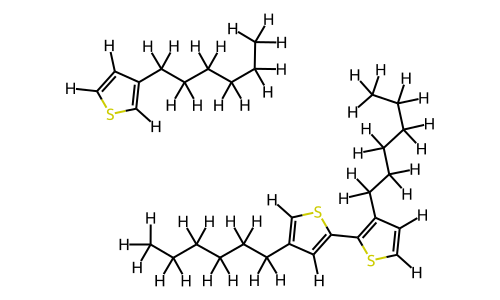

In [13]:
comp = Molecule.from_smiles(smiles)
bonds = [b for b in comp.bonds]
for i in range(len(bonds)):
    bonds[i].bond_order = 1
    #print(bonds[i].bond_order)
b= BondWalker(comp)
molecule = b.fill_in_bonds()
molecule.visualize()

In [14]:

#molecule = Molecule.from_smiles(smiles)
molecule_graph = esp.Graph(molecule)

espaloma_model = torch.load("espaloma_model.pt")
espaloma_model(molecule_graph.heterograph)

openmm_system = esp.graphs.deploy.openmm_system_from_graph(molecule_graph,charge_method="nn")

# Store the results for each in something more accessible
pair_forces = openmm_system.getForces()[1]
angle_forces = openmm_system.getForces()[3]
bond_forces = openmm_system.getForces()[2]
torsion_forces = openmm_system.getForces()[0]


# get a parmed structure from openmm 
topology = molecule.to_topology()
openmm_topology = topology.to_openmm()

structure = pmd.openmm.load_topology(topology=openmm_topology, system=openmm_system)
structure.bonds.sort(key=lambda x: x.atom1.idx)



for i in range(len(molecule.atoms)):
    if molecule.atoms[i].atomic_number == 6:
        molecule.atoms[i].name = 'C'
    if molecule.atoms[i].atomic_number == 1:
        molecule.atoms[i].name = 'H'
    if molecule.atoms[i].atomic_number == 7:
        molecule.atoms[i].name = 'N'
    if molecule.atoms[i].atomic_number == 16:
        molecule.atoms[i].name = 'S'
    if molecule.atoms[i].atomic_number == 8:
        molecule.atoms[i].name = 'O'
    if molecule.atoms[i].atomic_number == 9:
        molecule.atoms[i].name = 'F'
        
Gopenmm = nx.Graph()
Gparmed = nx.Graph()

#openmm:
for i in range(bond_forces.getNumBonds()):
    Gopenmm.add_edge(bond_forces.getBondParameters(index=i)[0],bond_forces.getBondParameters(index=i)[1])
#parmed
for b in structure.bonds:
    Gparmed.add_edge(b.atom1.idx,b.atom2.idx)
    
particle_types = []
type_map = dict()

#nx.rooted_tree_isomorphism
#in here we still need to check that one known index on one corresponds to the same index on the other....
tree_openmm = nx.bfs_tree(Gopenmm,0)
tree_parmed = nx.bfs_tree(Gparmed,0)
if nx.is_isomorphic(Gopenmm,Gparmed):
#if nx.isomorphism.tree_isomorphism(tree_openmm,tree_parmed):  <- want this work
    for i in range(pair_forces.getNumParticles()):
        pair_parms = pair_forces.getParticleParameters(index=i)
        sigma = pair_parms[1]/pair_parms[1].unit
        epsilon = pair_parms[2]/pair_parms[2].unit
        if (sigma, epsilon) not in particle_types: 
            particle_types.append((sigma, epsilon))
        type_map[molecule.atoms[i].molecule_atom_index] = "".join([molecule.atoms[i].name , 
                                                                   str(particle_types.index((sigma, epsilon)))])
        

bond_types = []
bond_dict = dict() 

for i in range(bond_forces.getNumBonds()):
    bond_parms = bond_forces.getBondParameters(index=i)
    l0 = bond_parms[2]/bond_parms[2].unit
    k = bond_parms[3]/bond_parms[3].unit
    bond_dict[type_map[bond_parms[0]],type_map[bond_parms[1]]] = {'k':k,'l0':l0}


angle_types = []
angle_dict = dict()

for i in range(angle_forces.getNumAngles()):
    angle_parms = angle_forces.getAngleParameters(index=i)
    k = angle_parms[4]/angle_parms[4].unit
    t0 = angle_parms[3]/angle_parms[3].unit  
    angle_dict[type_map[angle_parms[0]],type_map[angle_parms[1]],type_map[angle_parms[2]]] = {'k':k,'t0':t0}



dihedral_types = []
dihedral_dict = {}

for i in range(torsion_forces.getNumTorsions()):
    if i%6==0:
        periodicity=[]
        phase = []
        k = []
    dihedral_parms = torsion_forces.getTorsionParameters(index=i)
    periodicity.append(dihedral_parms[4])  
    phase.append( dihedral_parms[5]/dihedral_parms[5].unit)
    k.append(dihedral_parms[6]/dihedral_parms[6].unit)
    dt = (type_map[dihedral_parms[0]],type_map[dihedral_parms[1]],type_map[dihedral_parms[2]],
                  type_map[dihedral_parms[3]])
   

    if periodicity[-1]==6:
        dihedral_dict[dt] = {'periodicity':periodicity,'k':k,'phase':phase}


nonbonded_types = []
nonbonded_dict = {}

for i in range(pair_forces.getNumParticles()):
    nonbonded_parms = pair_forces.getParticleParameters(index=i)
    charge = nonbonded_parms[0]/nonbonded_parms[0].unit
    sigma = nonbonded_parms[1]/nonbonded_parms[1].unit
    epsilon = nonbonded_parms[2]/nonbonded_parms[2].unit
    nonbonded_types.append((charge,sigma,epsilon))
    nonbonded_dict[(type_map[i])]={'charge':charge,'sigma':sigma,'epsilon':epsilon}

In [21]:
molecule.to_file('molecule.mol',file_format='mol')

In [16]:
!obabel molecule.mol -O intermediate.mol2

1 molecule converted


In [17]:
!rm molecule.mol

In [18]:
test = mb.load('intermediate.mol2')
#test.energy_minimize()
test.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [20]:
for index in type_map:
    #print(index, type_map[index],test[index].name)
    test[index].name = type_map[index]
    
test.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
!rm intermediate.mol2

#### If you need to remove the dimer from the mbuild compound: do it using the children:

In [ ]:
t1 = test.children[0]
t2 = test.children[1]
t3 = test.children[2]
t4 = test.children[3]

In [ ]:
t2.visualize()

In [ ]:
test.remove(objs_to_remove=t2)
test.remove(objs_to_remove=t4)

In [ ]:
test.energy_minimize()
test.visualize()

In [ ]:
mbuild_to_foyer_xml(
    file_name=xml_filepath,
    compound=test,
    bond_params=bond_dict,
    angle_params=angle_dict,
    dihedral_params=dihedral_dict,
    dihedral_type="periodic",
    non_bonded_params=nonbonded_dict,
    combining_rule="geometric",
    name="",
    version="",
    coulomb14scale=1.0,
    lj14scale=1.0)

test.save(typed_mol2,overwrite=True)